In [1]:
!pip install tensorflow-addons==0.16.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [2]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


In [3]:
# Configuration
IMG_SIZE = (180, 180)
BATCH_SIZE = 32
EPOCHS = 100
SEED = 42
CLASS_NAMES = ['Eczema', 'ACNE', 'Psoriasis']
BASE_PATH = "/kaggle/input/acne-psoriasis-eczema-dataset/Acne_Psoriasis_Eczema_Dataset/"

# 1. Data Preparation
def create_dataframe():
    data_dict = {"image_path": [], "target": []}
    
    class_info = [
        ("1. Eczema 1677", 0),
        ("ACNE", 1),
        ("Psoriasis", 2)
    ]
    
    for class_dir, label in class_info:
        full_path = os.path.join(BASE_PATH, class_dir)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Directory not found: {full_path}")
            
        for img_file in os.listdir(full_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(full_path, img_file)
                data_dict["image_path"].append(img_path)
                data_dict["target"].append(label)
                
    return pd.DataFrame(data_dict)

df = create_dataframe()
print("Class distribution:\n", df['target'].value_counts())

Class distribution:
 target
0    9327
2    3812
1    3198
Name: count, dtype: int64


In [4]:

# 2. Handle Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)

# 3. Image Loading and Preprocessing
def load_images(df):
    images = []
    labels = []
    
    for idx, row in df.iterrows():
        try:
            img = cv2.imread(row['image_path'])
            if img is None:
                raise ValueError("Could not read image")
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(row['target'])
        except Exception as e:
            print(f"Error processing {row['image_path']}: {str(e)}")
    
    return np.array(images), np.array(labels)

images, labels = load_images(df)



Class weights: {0: 0.5838604767520817, 1: 1.7028351052741297, 2: 1.4285589366911509}


In [5]:

# 4. Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    images, 
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)

# 5. Feature Extraction with VGG19
def create_feature_extractor():
    base_model = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    base_model.trainable = False
    return base_model

vgg_model = create_feature_extractor()

def extract_features(images, model):
    features = model.predict(images, verbose=0)
    return features.reshape(features.shape[0], -1)

print("\nExtracting training features...")
X_train_features = extract_features(X_train, vgg_model)
print("Extracting test features...")
X_test_features = extract_features(X_test, vgg_model)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Extracting training features...
Extracting test features...


In [6]:

# 6. Simplified Model Architecture
def build_model(input_shape):
    model = Sequential([
        Dense(512, activation='relu', 
              input_shape=input_shape,
              kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(256, activation='relu',
              kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model((X_train_features.shape[1],))
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,686,211 (25.51 MB)

 Trainable params: 6,686,211 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# 7. Training with Essential Callbacks Only
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1
    )
]

history = model.fit(
    X_train_features, y_train,
    validation_data=(X_test_features, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5045 - loss: 17.3463 - val_accuracy: 0.5939 - val_loss: 12.6243 - learning_rate: 1.0000e-04
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6002 - loss: 12.5377 - val_accuracy: 0.6252 - val_loss: 11.3762 - learning_rate: 1.0000e-04
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6343 - loss: 11.1189 - val_accuracy: 0.6735 - val_loss: 10.2304 - learning_rate: 1.0000e-04
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6681 - loss: 9.9265 - val_accuracy: 0.7056 - val_loss: 9.1017 - learning_rate: 1.0000e-04
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6976 - loss: 8.7739 - val_accuracy: 0.6986 - val_loss: 8.0797 - learning_rate: 1.0000e-04
Epoch 6/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7161 - loss: 7.7102 - val_accuracy: 0.7084 - val_loss: 7.0743 - learning_rate: 1.0000e-04
Epoch 7/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:
              precision    recall  f1-score   support

      Eczema       0.89      0.76      0.82      1866
        ACNE       0.96      0.88      0.91       640
   Psoriasis       0.59      0.84      0.70       762

    accuracy                           0.80      3268
   macro avg       0.81      0.83      0.81      3268
weighted avg       0.83      0.80      0.81      3268



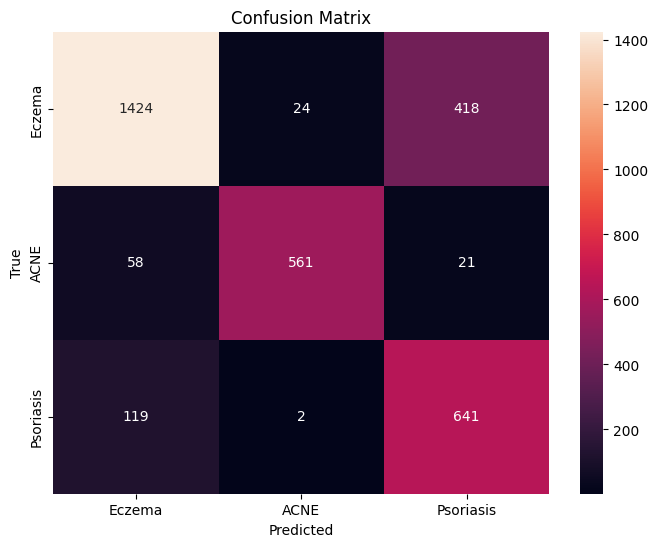

In [8]:
# 8. Post-Training Evaluation
y_pred = np.argmax(model.predict(X_test_features), axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [9]:
# 9. Save Model
model.save('skin_disease_classifier_v2.h5')
print("Model saved successfully!")

Model saved successfully!


In [10]:
import shutil
shutil.move('skin_disease_classifier_v2.h5', '/kaggle/working/skin_disease_classifier_v2.h5')


'/kaggle/working/skin_disease_classifier_v2.h5'

In [11]:
# Load the saved model (if not already loaded)
from tensorflow.keras.models import load_model
import numpy as np

# 1. Load the trained model
model = load_model('skin_disease_classifier_v2.h5')

# 2. Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_features, y_test, verbose=0)

# 3. Print results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Optional: Detailed prediction analysis
from sklearn.metrics import accuracy_score

# Make predictions
y_pred = model.predict(X_test_features)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate manual accuracy (should match evaluate() result)
manual_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nManual Accuracy Check: {manual_accuracy * 100:.2f}%")

# Confirmation check
assert np.isclose(test_accuracy, manual_accuracy), "Accuracy values should match!"

Test Accuracy: 80.35%
Test Loss: 0.7318
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Manual Accuracy Check: 80.35%
